In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import  GridSpec
import numpy as np
from matplotlib.lines import Line2D

from matplotlib import colors
from matplotlib import cm
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

#from osgeo import gdal
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import Point
import fiona
#import rasterio
#from rasterio.plot import show

import os
#import richdem as rd

#import elevation

import glob
%matplotlib inline

In [3]:
figure_path = "./output_figures/"
isExist = os.path.exists(figure_path)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(figure_path)

# Plot pollen data for overview figure

In [4]:
bog_sites_df = pd.read_csv('./bm_data/table_1.csv', encoding = "windows-1254")
#I had this table in the manuscript. I was working in UTM but want lat/long for submission

geometry = [Point(xy) for xy in zip(bog_sites_df['Easting (m)'], bog_sites_df['Northing (m)'])]
df_drop = bog_sites_df.drop(['Easting (m)', 'Northing (m)'], axis=1)
sites_18N = GeoDataFrame(df_drop, crs="EPSG:32618", geometry=geometry)
#I was working in 18N

bog_sites = sites_18N.to_crs('epsg:4326')
#But now make it latlong

#It's a shapefile for plotting but let's export a new csv for the manuscript
bog_sites['longitude'] = bog_sites.geometry.apply(lambda p: p.x)
bog_sites['latitude'] = bog_sites.geometry.apply(lambda p: p.y)

bog_sites.drop('geometry',axis=1).to_csv('table_1_latlong.csv', index=False) 

In [5]:
bog_sites_box=[bog_sites.total_bounds[0]-0.0025, bog_sites.total_bounds[2]+0.001, bog_sites.total_bounds[1]-0.001, bog_sites.total_bounds[3]+0.0025]
box_params = [(bog_sites_box[0],bog_sites_box[3]), (bog_sites_box[1]-bog_sites_box[0]), (bog_sites_box[2]-bog_sites_box[3])]

## Make plots

# Stingelin core graphic

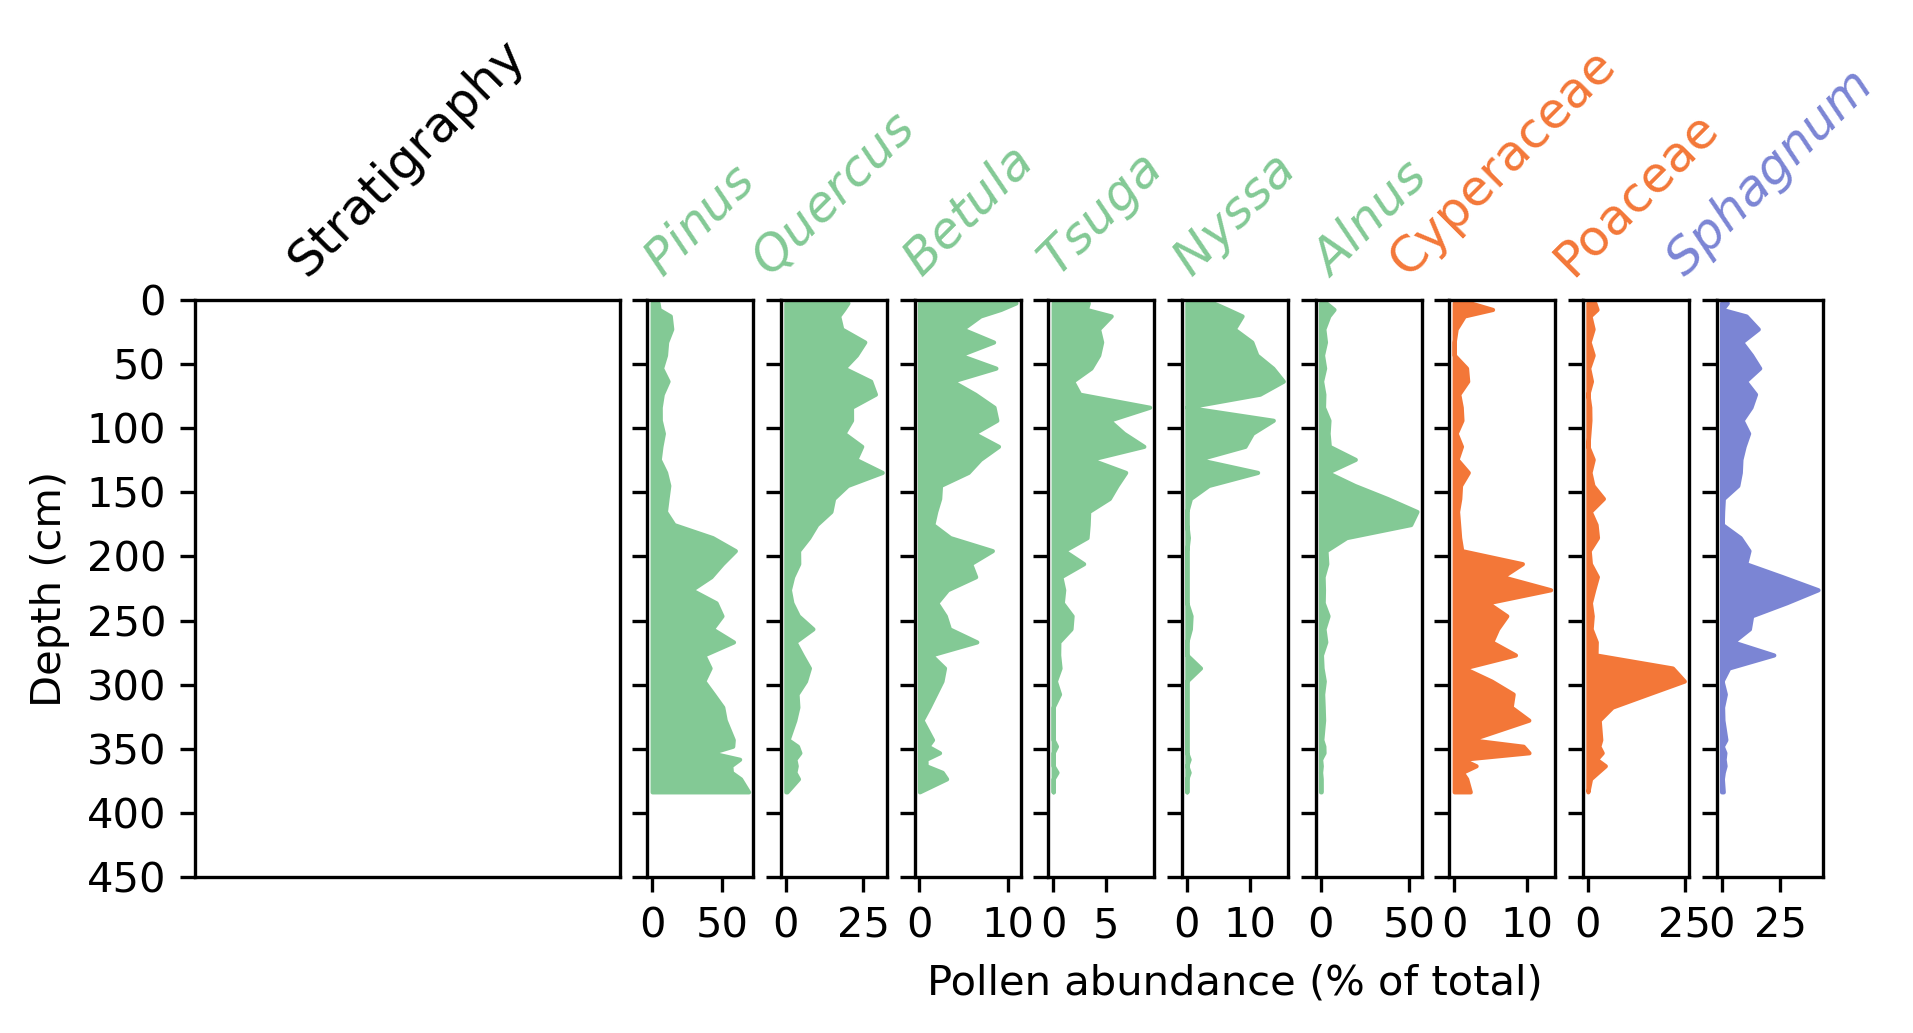

In [6]:
dfs = pd.read_csv("./bm_data/stingelin_correlation.csv")
fig, ax = plt.subplots(1,10,figsize=(7, 2.5), dpi=300, sharey=True, gridspec_kw={'width_ratios':[4,1,1,1,1,1,1,1,1,1]})

ax[0].set_title('Stratigraphy', rotation=45)
ax[0].set_xticklabels('')
ax[0].tick_params(bottom=False)


ax[1].fill_betweenx( dfs['Depth'], dfs['Pinus'], color='#83c995')
ax[1].set_title('$\it{Pinus}$', rotation=45, color='#83c995')
ax[2].fill_betweenx(dfs['Depth'], dfs['Quercus'], color='#83c995')
ax[2].set_title('$\it{Quercus}$', rotation=45, color='#83c995')
ax[3].fill_betweenx(dfs['Depth'], dfs['Betula'], color='#83c995')
ax[3].set_title('$\it{Betula}$', rotation=45, color='#83c995')
ax[4].fill_betweenx(dfs['Depth'], dfs['Tsuga'], color='#83c995')
ax[4].set_title('$\it{Tsuga}$', rotation=45, color='#83c995')
ax[5].fill_betweenx(dfs['Depth'], dfs['Nyssa'], color='#83c995')
ax[5].set_title('$\it{Nyssa}$', rotation=45, color='#83c995')
ax[6].fill_betweenx(dfs['Depth'], dfs['Alnus'], color='#83c995')
ax[6].set_title('$\it{Alnus}$', rotation=45, color='#83c995')

ax[7].fill_betweenx(dfs['Depth'], dfs['Cyperaceae'], color='#f37738')
ax[7].set_title('Cyperaceae', rotation=45, color='#f37738')
ax[8].fill_betweenx( dfs['Depth'], dfs['Poaceae'], color='#f37738')
ax[8].set_title('Poaceae', rotation=45, color='#f37738')

ax[9].fill_betweenx(dfs['Depth'], dfs['Sphagnum'], color='#7b85d4')
ax[9].set_title('$\it{Sphagnum}$', rotation=45, color='#7b85d4')






ax[0].set_ylim(384, 0)
for y in ax:
    y.set_yticks(range(0,500,50));
    
ax[0].set_ylabel("Depth (cm)")
ax[5].set_xlabel("Pollen abundance (% of total)")

fig.savefig('./output_figures/Stingelin_diagram.png',bbox_inches='tight')

# Load and plot raw measured core data

## Load XRF scan and grainsize csv

In [7]:
df = pd.read_csv("./bm_data/S02_core_log.csv")
dfg = pd.read_csv("./bm_data/S02_grainsize.csv").dropna()
dfo = pd.read_csv("./bm_data/S02_YASIC.csv")
dfo_red = dfo.groupby(np.arange(len(dfo))//2).mean()
#https://stackoverflow.com/questions/36810595/calculate-average-of-every-x-rows-in-a-table-and-create-new-table
dfo_red = dfo_red.dropna()

C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_19088\143501303.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfo_red = dfo.groupby(np.arange(len(dfo))//2).mean()


## Interpolate % grain size from percentiles

In [8]:
gs_percent = []
for sample in dfg.index:
    xcol = dfg.loc[sample,'d10':'d90']
    ycol = [10,20,30,40,50,90]
    gs_percent.append(np.interp([3.9, 62.5], xcol, ycol))
    
dfg[['%_clay', '%_silt']]=pd.DataFrame(gs_percent)

dfg['%_silt'] = dfg['%_silt'].replace(90.000000, 100)

dfg['%_silt'] = dfg['%_silt']-dfg['%_clay']

dfg['%_sand'] = 100 -(dfg['%_silt']+dfg['%_clay'])

dfg.to_csv("PH2_grainsize_interp.csv")



In [9]:
dfg_plot = dfg.replace('recore', np.nan).dropna().astype(float)

dfg_plot['%_cs'] = dfg['%_silt'] + dfg['%_clay']

## Make and save figure of raw measurements with depth 

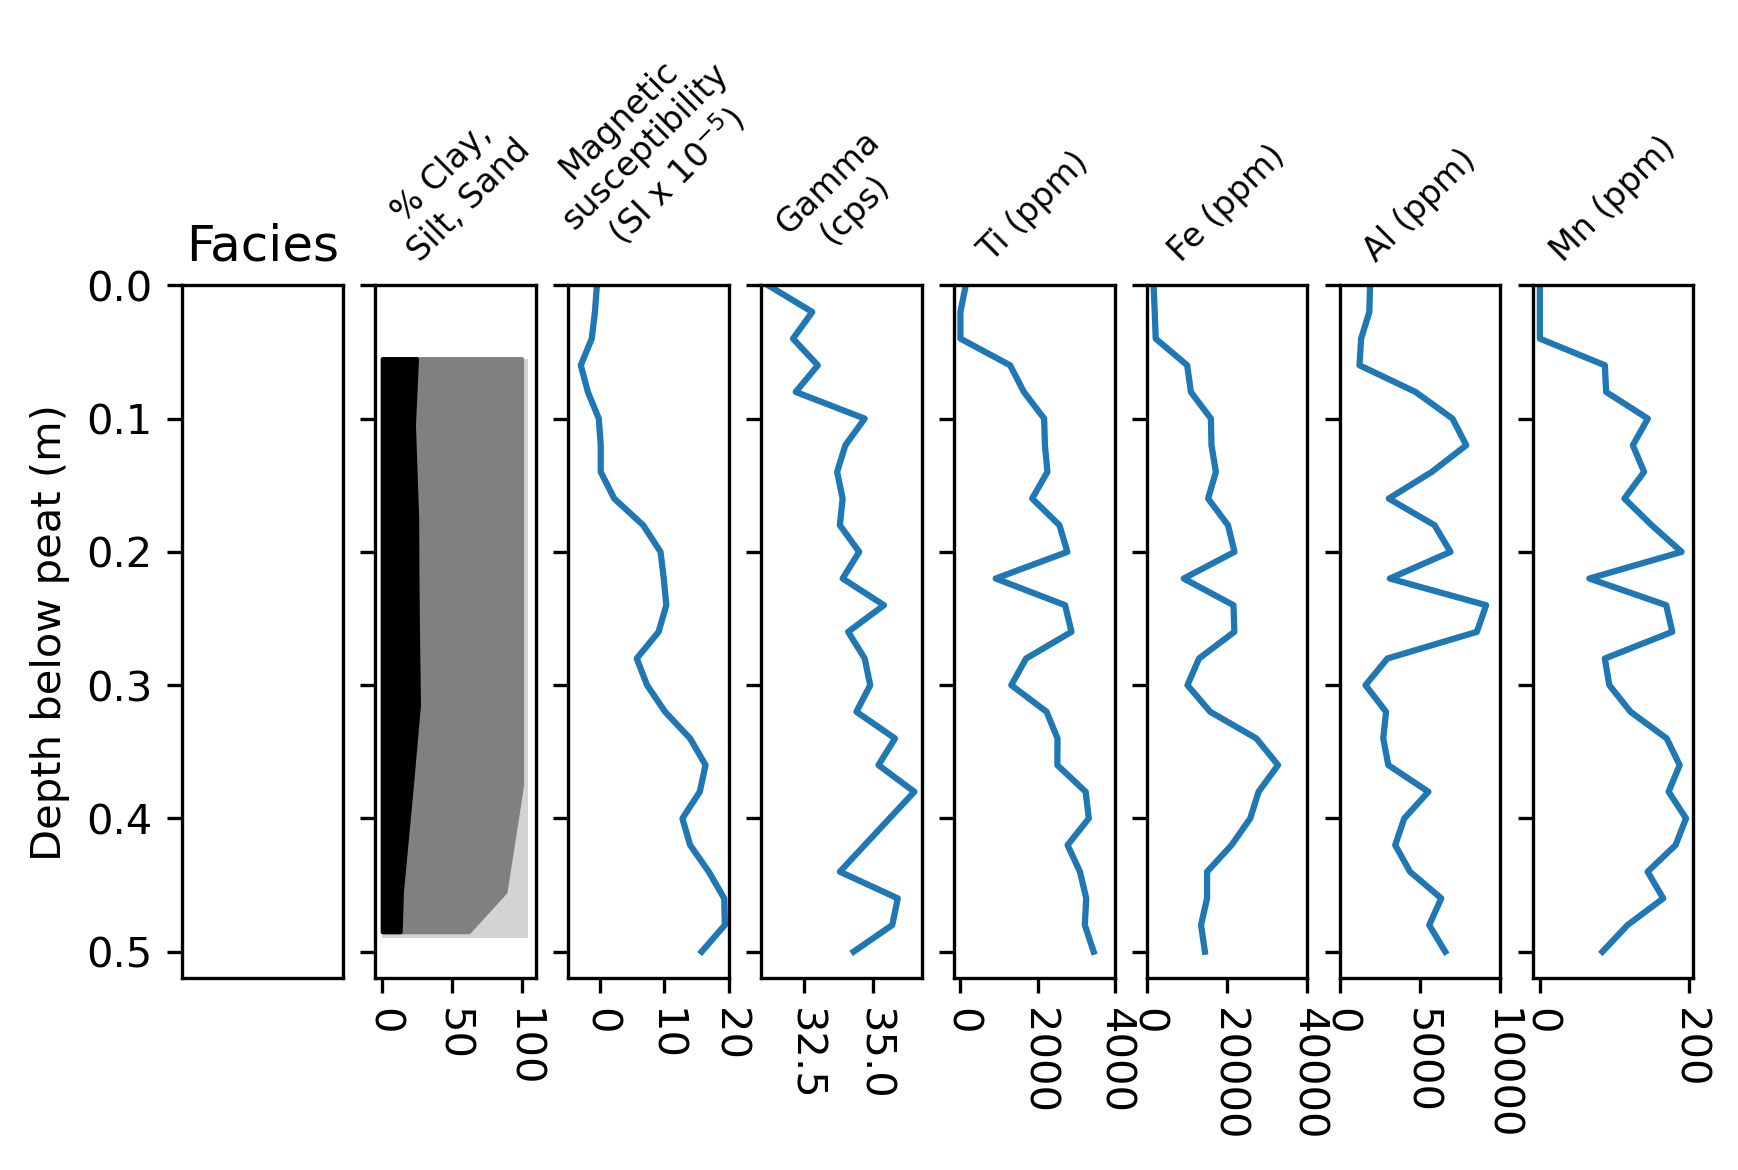

In [10]:
fig, ax = plt.subplots(1,8,figsize=(6.5,3),dpi=300,sharey=True)

ax[0].set_title('Facies')
ax[0].set_xticklabels('')
ax[0].tick_params(bottom=False)
ax[0].set_ylabel('Depth below peat (m)');

sand = matplotlib.patches.Rectangle((0,0.055),
                               width = 105,
                               height = .435,
                                   facecolor='lightgray')

ax[1].add_patch(sand)
ax[1].fill_betweenx((dfg_plot['depth adjusted']/100),dfg_plot['%_clay'], color='black', zorder=3)
ax[1].fill_betweenx((dfg_plot['depth adjusted']/100),(dfg_plot['%_cs']), color='gray', zorder=2)
ax[1].set_xticks(range(0,150,50))
ax[1].set_title('% Clay,\nSilt, Sand',fontsize=8, rotation=45)
ax[1].set_ylim(0.50, 0.0)

ax[2].plot(df['mag_sus'],df['depth_adj'])
ax[2].set_title('Magnetic\nsusceptibility\n(SI x $10^{-5}$)',fontsize=8, rotation=45)
ax[2].set_ylim(0.52, 0.0)
ax[2].set_xlim(-5,20)
ax[2].set_xticks(range(0,25,10))

ax[3].plot(df['nat_gam'],df['depth_adj'])
ax[3].set_title('Gamma\n(cps)',fontsize=8, rotation=45)






ax[4].plot(df['Ti'],df['depth_adj'])
ax[4].set_title('Ti (ppm)',fontsize=8, rotation=45)
ax[4].set_xticks(range(0,6000,2000))

ax[5].plot(df['Fe'],df['depth_adj'])
ax[5].set_title('Fe (ppm)',fontsize=8, rotation=45)
ax[5].set_xticks(range(0,60000,20000))

ax[6].plot(df['Al'],df['depth_adj'])
ax[6].set_title('Al (ppm)',fontsize=8, rotation=45)
ax[6].set_xticks(range(0,15000,5000))

ax[7].plot(df['Mn'],df['depth_adj'])
ax[7].set_title('Mn (ppm)',fontsize=8, rotation=45)

for x in ax:
    x.tick_params(axis='x',rotation=-90)

#plt.suptitle('Bear Meadows S-02', y=1.1, fontsize=16)
fig.savefig('./output_figures/S-02_XRF_gs_plots.png',bbox_inches='tight')

# PCA

## Define PCA function

In [11]:
def pcaplot(variable,pca_df,coeff,per_var,colors,sym_list,s=50,labels=None):
    fig, ax = plt.subplots(figsize=(3.5,3.5),dpi=150)
    
    ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.6)
    ax.axvline(x=0, linestyle='-', linewidth=1, color='k', alpha=0.6)

    n = coeff.shape[0]
    
    coeff_scale = 7
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0]*coeff_scale, coeff[i,1]*coeff_scale, color = 'gray', alpha = 0.25)
        if labels is None:
            ax.text(coeff[i,0]* coeff_scale+0.15, coeff[i,1] * coeff_scale+0.15,
                    "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* coeff_scale, coeff[i,1] * coeff_scale,
                    labels[i], color = 'k', ha = 'center', va = 'center', fontsize=6)
    
    for i, u  in enumerate(pca_df[variable].unique()):
        df = pca_df[pca_df[variable] == u]
        col = colors.loc[df.index]
        xs = df.PC1
        ys = df.PC2
        #n = coeff.shape[0]
#         scalex = 1.0/(xs.max() - xs.min())
#         scaley = 1.0/(ys.max() - ys.min())
        scalex = scaley = 1.0
        ax.scatter(xs * scalex,ys * scaley, s=s, c = col, marker=sym_list[i],alpha=.75,edgecolors='k',label=u)
    

#     ax.set_xlim(-.6,.6)
#     ax.set_ylim(-.6,.6)
    ax.set_xlabel("PC1 - {0}%".format(per_var[0]))
    ax.set_ylabel("PC2 - {0}%".format(per_var[1]))
    ax.grid(ls='--')
    ax.set_axisbelow(True)

#     legend_elements = [Line2D([0],[0],marker='o',lw=0,color=c_list[i],label=str(cluster_list[i]),
#                          markerfacecolor=c_list[i],markersize=5) for i in range(0,len(lut))]
#     ax.legend(handles=legend_elements,loc='lower center', bbox_to_anchor=(1.5, -0.05), fontsize=8)

    ax.legend()
    return fig, ax

## Load in csv with hillslope samples and elements and isolate heavy elements and high thresholds

In [12]:
heavy_elements = ['Ti', 'Zr', 'Mn', 'Fe', 'V', 'Cr', 'Ni', 'Cu', 'Zn', 'As', 'Ag', 'Cd',
       'Sn', 'Sb', 'Pb', 'Bi']
hi_threshold_elements = ['Ti', 'Zr', 'Mn', 'Fe', 'V', 'Cr', 'Zn', 'Ag', 'Cd', 'Sn', 'Sb', 'Pb',
       'LE', 'Al', 'Si', 'K', 'Ca']

In [13]:
df2 = pd.read_csv("./bm_data/S02_with_hillslope.csv")
#df2 = pd.read_csv("hillslope_samples.csv")

hs_cols = []

hs_data = df2.iloc[:, 8:] #heavies and lights

hs_data = hs_data.dropna(axis=1)
hs_data.columns

Index(['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Ni', 'Cu', 'Zn', 'As', 'Zr', 'Ag', 'Cd',
       'Sn', 'Sb', 'Pb', 'Bi', 'LE', 'Mg', 'Al', 'Si', 'P', 'K', 'Ca'],
      dtype='object')

## Make a new PCA with hillslope and bog data

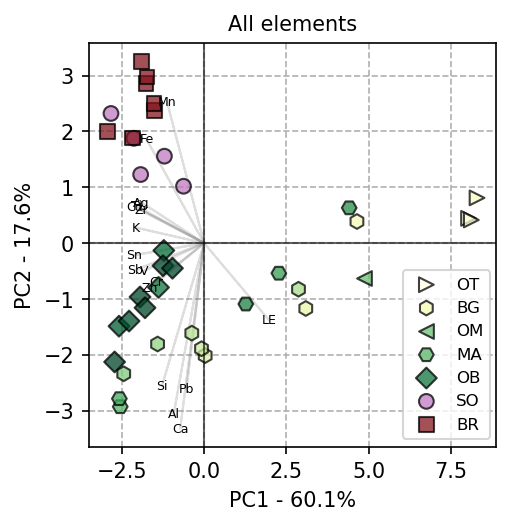

In [14]:

hs_data = hs_data[hi_threshold_elements]

scaled_data = preprocessing.scale(hs_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=hs_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=hs_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=hs_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
sorted_loading_scores2 = loading_scores2.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=hs_data.index,columns=labels)
pca_df = pd.merge(pca_df,df2['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)

colors[df2.index[df2['unit_desc']=='SO']]='#BF7AC1'

colors[df2.index[df2['unit_desc']=='BR']]='#84151E'


sym_list = ['>','h','<','H','D','o','s']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.legend(loc='lower center', bbox_to_anchor=(.88, 0), fontsize=8)

ax.set_title('All elements',fontsize=10)

fig.savefig('./output_figures/all_elements.svg', dpi=300)



## Merge PCA and core data including age model

In [15]:
agePCA_all_elements = pd.merge(df, pca_df,left_index=True,right_index=True)
loading = pd.DataFrame(data=loading_scores.values, index=loading_scores.index, columns=['PC1','PC2','PC3'])
loading.to_csv('loading_scores_all_elements.csv',index=True)


## Same thing but with heavy elements only

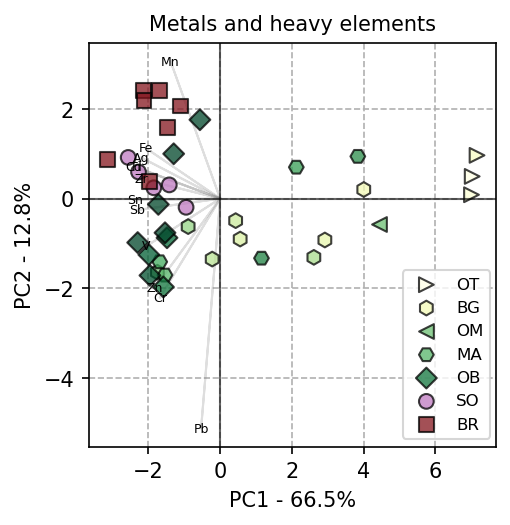

In [16]:
hs_data = df2[list(set(heavy_elements) & set(hi_threshold_elements))]


scaled_data = preprocessing.scale(hs_data)

# create pca object
pca = PCA()
# calculate loading scores and variation each PC accounts for
pca.fit(scaled_data)
# generate coords for graph based on loading scores and scaled data
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
cum_per_var = np.cumsum(per_var)
# calculate percentage of variation each PC accounts for

total_pcs = list(range(1, len(per_var)+1))
labels = ['PC'+str(x) for x in total_pcs]

# the loading scores are the proportions that make up the PCs
loading_scores1 = pd.Series(pca.components_[0], index=hs_data.columns)
loading_scores2 = pd.Series(pca.components_[1], index=hs_data.columns)
loading_scores3 = pd.Series(pca.components_[2], index=hs_data.columns)
loading_scores = pd.concat([loading_scores1,loading_scores2,loading_scores3],axis=1)

sorted_loading_scores1 = loading_scores1.abs().sort_values(ascending=False)
top_10_1 = sorted_loading_scores1[0:].index.values
loading_scores1[top_10_1];

pca_df = pd.DataFrame(pca_data, index=hs_data.index,columns=labels)
pca_df = pd.merge(pca_df,df2['unit_desc'],left_index=True, right_index=True)

cluster_list = df2['depth_adj'].unique()
# set colormap
low = 0
high = 1.25
number_of_lines= len(cluster_list)
cm_subsection = np.linspace(low, high, number_of_lines) 
cmap = plt.cm.get_cmap("YlGn")
c_list = [ cmap(x) for x in cm_subsection ]
c_list[:-1]
lut = dict(zip(cluster_list, c_list))
colors = df2['depth_adj'].map(lut)

colors[df2.index[df2['unit_desc']=='SO']]='#BF7AC1'

colors[df2.index[df2['unit_desc']=='BR']]='#84151E'


sym_list = ['>','h','<','H','D','o','s']
sut = dict(zip(df2['unit_desc'].unique(), sym_list))
symbols = df2['unit_desc'].map(sut)


coeff = np.transpose(pca.components_[[0,1], :]) # take the first two PCs
fig, ax = pcaplot('unit_desc',pca_df, coeff=coeff, per_var=per_var,
                  colors=colors,sym_list=sym_list,labels=loading_scores.index)
ax.legend(loc='lower center', bbox_to_anchor=(.88, 0), fontsize=8)

ax.set_title('Metals and heavy elements',fontsize=10)

fig.savefig('./output_figures/heavy_elements.svg', dpi=300)

In [17]:
loading = pd.DataFrame(data=loading_scores.values, index=loading_scores.index, columns=['PC1','PC2','PC3'])
loading.to_csv('loading_scores_heavy_elements.csv',index=True)

## Merge PCA and core measurements, including age model

In [18]:
agePCA = pd.merge(df,pca_df,left_index=True,right_index=True)

# Time series

In [19]:
dfs = pd.read_csv("./bm_data/stingelin.csv")
dfo = pd.read_csv("./bm_data/NGRIP/oxygen.csv")
dfb = pd.read_csv("./bm_data/stingelin_bacon.csv")
dfd = pd.read_csv("./bm_data/NGRIP/NGRIP_dust.csv")
dfr = pd.read_csv("./bm_data/radiocarbon.csv")

In [20]:
dfb

,depth,min,max,median,mean
0,144.78,8451,8758,8581,8580
1,145.78,8470,8802,8614,8617
2,146.78,8484,8876,8647,8654
3,147.78,8495,8964,8679,8692
4,148.78,8504,9057,8709,8729
...,...,...,...,...,...
148,292.78,13082,14680,13930,13914
149,293.78,13159,14793,14039,14018
150,294.78,13244,14850,14112,14095
151,295.78,13313,14911,14180,14166


## Assign Bacon ages to Stingelin depths

In [21]:
merged = pd.merge(dfs, dfb, on="depth", how="outer")
merged = merged.sort_values(by="depth").interpolate(
    # limit_area='inside',
    limit_direction='both',
    limit=1,
    )

dfs['age_interpolated'] = dfs['depth'].map(
    dict(zip(merged['depth'], merged['mean']))
    )
# dfs['age_extrapolated']
dfs

,depth,strat,Abies,Acer,Alnus,Aquifoliaceae,Asteraceae,Betula,Carya,Castanea,...,Tsuga,Ulmus,Unknown,Utricularia,Viburnum,tree,her,gymnos,hot,age_interpolated
0,2.54,peat,0.222717,0.668151,3.118040,0.668151,21.826281,10.913140,1.336303,0.000000,...,3.340757,0.668151,5.122494,0.000000,0.668151,86.859688,25.835189,8.017817,38.530067,NaN
1,7.62,peat,0.262467,0.262467,7.611549,1.837270,20.734908,9.186352,1.049869,1.574803,...,3.149606,0.524934,7.086614,0.000000,3.149606,81.889764,28.346457,9.186352,39.107612,NaN
2,12.70,peat,0.000000,0.275482,4.683196,2.754821,4.407713,6.887052,0.826446,5.785124,...,5.509642,0.826446,5.509642,0.000000,2.479339,79.063361,6.336088,19.008264,37.741047,NaN
3,22.86,peat,0.269542,0.000000,1.886792,3.504043,2.695418,4.851752,1.078167,5.121294,...,4.312668,0.808625,2.695418,0.000000,1.078167,77.358491,4.312668,21.293801,33.692722,NaN
4,33.02,peat,0.164474,1.315789,2.796053,1.973684,0.986842,8.388158,2.467105,5.921053,...,4.605263,0.328947,4.934211,0.000000,0.822368,82.565789,1.315789,15.953947,47.697368,NaN
5,43.18,peat,0.000000,1.138952,1.138952,1.366743,1.138952,4.555809,1.594533,8.200456,...,4.328018,0.227790,3.872437,0.000000,1.366743,77.448747,2.505695,14.350797,40.774487,NaN
6,53.34,peat,0.000000,0.843882,2.320675,1.265823,1.898734,8.649789,0.843882,6.962025,...,3.586498,0.421941,3.797468,0.000000,0.632911,72.784810,3.797468,10.759494,40.506329,NaN
7,63.50,peat,0.000000,0.307692,0.615385,0.923077,1.230769,3.692308,1.538462,7.384615,...,1.846154,0.000000,3.692308,0.000000,0.923077,81.846154,4.000000,15.076923,43.076923,NaN
8,73.66,peat,0.000000,1.572327,1.886792,0.943396,0.943396,6.289308,1.572327,8.176101,...,2.515723,0.000000,5.660377,0.000000,0.628931,77.358491,1.572327,10.062893,49.056604,NaN
9,83.82,peat,0.000000,0.722892,1.686747,2.891566,0.722892,8.433735,0.963855,8.192771,...,9.156627,0.963855,3.614458,0.000000,1.927711,74.939759,2.168675,15.421687,45.542169,NaN


## Load all databases, clean data

In [22]:
# dfs = pd.read_csv("./bm_data/stingelin_correlation.csv")
# dfo = pd.read_csv("./bm_data/NGRIP/oxygen.csv")
# dfb = pd.read_csv("./bm_data/bacon_ages.csv")
# dfd = pd.read_csv("./bm_data/NGRIP/NGRIP_dust.csv")
# dfr = pd.read_csv("./bm_data/radiocarbon.csv")

In [23]:
# Calculate accumulation rate
dfs_accum = np.zeros(len(dfs['depth']))

for x in range (0, len(dfs['depth'])-1):
    dfs_accum[x] = (dfs['depth'][x+1]-dfs['depth'][x])/(dfs['age_interpolated'][x+1]-dfs['age_interpolated'][x])
    
dfs_accum[-1] = np.nan


C:\Users\Joanmarie\AppData\Local\Temp\ipykernel_19088\1715753458.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  dfs_accum[x] = (dfs['depth'][x+1]-dfs['depth'][x])/(dfs['age_interpolated'][x+1]-dfs['age_interpolated'][x])


In [24]:
# Limit NGRIP data to the time intervals in which you are interested
o18_sub_age = dfo['Age'][0::2]
o18_sub_ox = dfo['d18O'][0::2]

## Make and save time series figures

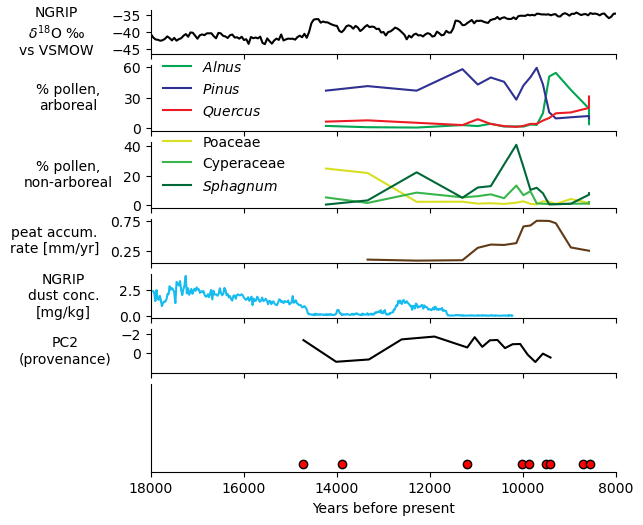

In [25]:
fig, ax = plt.subplots(7,1,figsize=(6,6),sharex=True, frameon=False, gridspec_kw={'height_ratios':[1,1.5,1.5,1,1,1,2]})
# fig, ax = plt.subplots(2,4)

ax[0].plot(o18_sub_age, o18_sub_ox, color='k')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
#ax[0].spines['bottom'].set_visible(False)
# ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax[0].set_ylabel('NGRIP\n$\delta^{18}$O ‰\nvs VSMOW', rotation=0, labelpad=40, va='center')


#ax[1].plot(dfs['mean age'],(dfs['Abies']+dfs['Picea']),label='Abies+Picea')
ax[1].plot(dfs['age_interpolated'],(dfs['Alnus']), label='$\it{Alnus}$', color='#00A651')
ax[1].plot(dfs['age_interpolated'],(dfs['Pinus']), label='$\it{Pinus}$', color='#2E3192')
ax[1].plot(dfs['age_interpolated'],(dfs['Quercus']), label = '$\it{Quercus}$', color='#ED1C24')
#ax[1].plot(dfs['mean age'],(dfs['Tsuga']))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_yticks([0,30,60])
#ax[1].spines['bottom'].set_visible(False)
ax[1].legend()
ax[1].set_ylabel('% pollen,\narboreal', rotation=0, labelpad=40, va='center')
ax[1].legend(loc='lower left',
#  bbox_to_anchor=(.95, 0),
  frameon=False
 )
# h, l = ax[1].get_legend_handles_labels()
#ax[1].legend(labels = [l])

ax[2].plot(dfs['age_interpolated'],(dfs['Poaceae']), label='Poaceae', color='#D7DF23')
ax[2].plot(dfs['age_interpolated'],(dfs['Cyperaceae']), label='Cyperaceae', color='#39B54A')
ax[2].plot(dfs['age_interpolated'],(dfs['Sphagnum']), label='$\it{Sphagnum}$', color='#006838')
ax[2].set_ylabel('% pollen,\nnon-arboreal', rotation=0, labelpad=40, va='center')
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_yticks([0,20,40])
ax[2].legend(loc='lower left',
#  bbox_to_anchor=(.972, 0),
  frameon=False
 )
#ax[2].spines['bottom'].set_visible(False)

# ax[3].plot(dfs['mean age'],(dfs['Sphagnum']))
# ax[3].spines['top'].set_visible(False)
# ax[3].spines['right'].set_visible(False)
# #ax[3].spines['bottom'].set_visible(False)

ax[3].plot(dfs['age_interpolated'], dfs_accum*10, color='#603917')
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
#ax[3].spines['bottom'].set_visible(False)
# ax[3].legend(['acc rate, Stingelin'], bbox_to_anchor=(1.0, 1.0), loc='upper left')
ax[3].set_ylabel('peat accum.\nrate [mm/yr]', rotation=0, labelpad=40, va='center')
ax[3].set_yticks([0.25,0.75])

ax[4].plot(dfd['age_ka'], dfd['Dust conc [microg/kg]']*0.001, color='#16BBEF', label='Greenland ice dust concentration')
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].set_ylabel('NGRIP\ndust conc.\n[mg/kg]', rotation=0, labelpad=40, va='center')

# ax[5].spines['top'].set_visible(False)
# ax[5].spines['right'].set_visible(False)
# ax[5].plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
# ax[5].set_ylabel('PC1\n(organics)')
ax[5].plot(agePCA['age_interpolated'], agePCA['PC2'], 'k')
ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].set_ylabel('PC2\n(provenance)',rotation=0, labelpad=40, va='center')
ax[5].set_yticks([0,-2.0])
ax[5].set_ylim((2.1,-2.5))
# ax[5].hlines(pca_df['PC2'][pca_df['unit_desc']=='SO'].mean(), xmin=9500, xmax=21500, color='#BF7AC1')
# ax[5].hlines(pca_df['PC2'][pca_df['unit_desc']=='BR'].mean(), xmin=9500, xmax=21500, color='#84151E')
# ax[5].hlines(-2, xmin=9500, xmax=21500, color='#16BBEF')
# ax[5].yaxis.label.set_color('g')
# ax[5].tick_params(axis='y', colors='g')
# ax[5].spines['left'].set_color('g')

# ax[5].spines['top'].set_visible(False)
# ax[5].spines['right'].set_visible(False)
# ax[5].plot(agePCA.age_extrapolated, agePCA.PC1, 'g')
# ax[5].set_ylabel('PC1\n(organics)')
# ax2 = ax[5].twinx()
# ax2.plot(agePCA.age_extrapolated, agePCA.PC2, 'k')
# ax2.spines['top'].set_visible(False)
# ax2.set_ylabel('PC2\n(provenance)')
# ax[5].yaxis.label.set_color('g')
# ax[5].tick_params(axis='y', colors='g')
# ax[5].spines['left'].set_color('g')


ax[6].spines['top'].set_visible(False)
ax[6].spines['right'].set_visible(False)
ax[6].plot(dfr['median Cal ka'], np.zeros(len(dfr['median Cal ka'])), 'ro', mec='k')
ax[6].yaxis.set_visible(False)
# ax[6].set_yticklabels([])
# ax[6].set_yticks([])
# ax[6].set_ylabel('bog center\n\n\n\nbog edge',rotation=0, labelpad=40, va='center')
ax[6].set_ylim([-.1,1])

ax[0].set_xlim(18000,8000)
ax[6].set_xlabel('Years before present')
#ax[0].set_xticks(range(6000,22000,2000))

# fig.tight_layout()

fig.savefig('./output_figures/bog_time_data_new.svg', dpi=300)

## Make plot with depth/time

In [26]:
pd.to_numeric(df["depth_adj"])
result0=df[['depth_adj','age_interpolated']]
result=dfo_red.merge(result0,how='left',left_on='depth_adj', right_on='depth_adj')
result=result.interpolate(method='linear',limit_direction='backward')

In [46]:
bedrock_PC2_mean = pca_df.loc[pca_df['unit_desc'] == 'BR']['PC2'].mean()
soil_PC2_mean = pca_df.loc[pca_df['unit_desc'] == 'SO']['PC2'].mean()

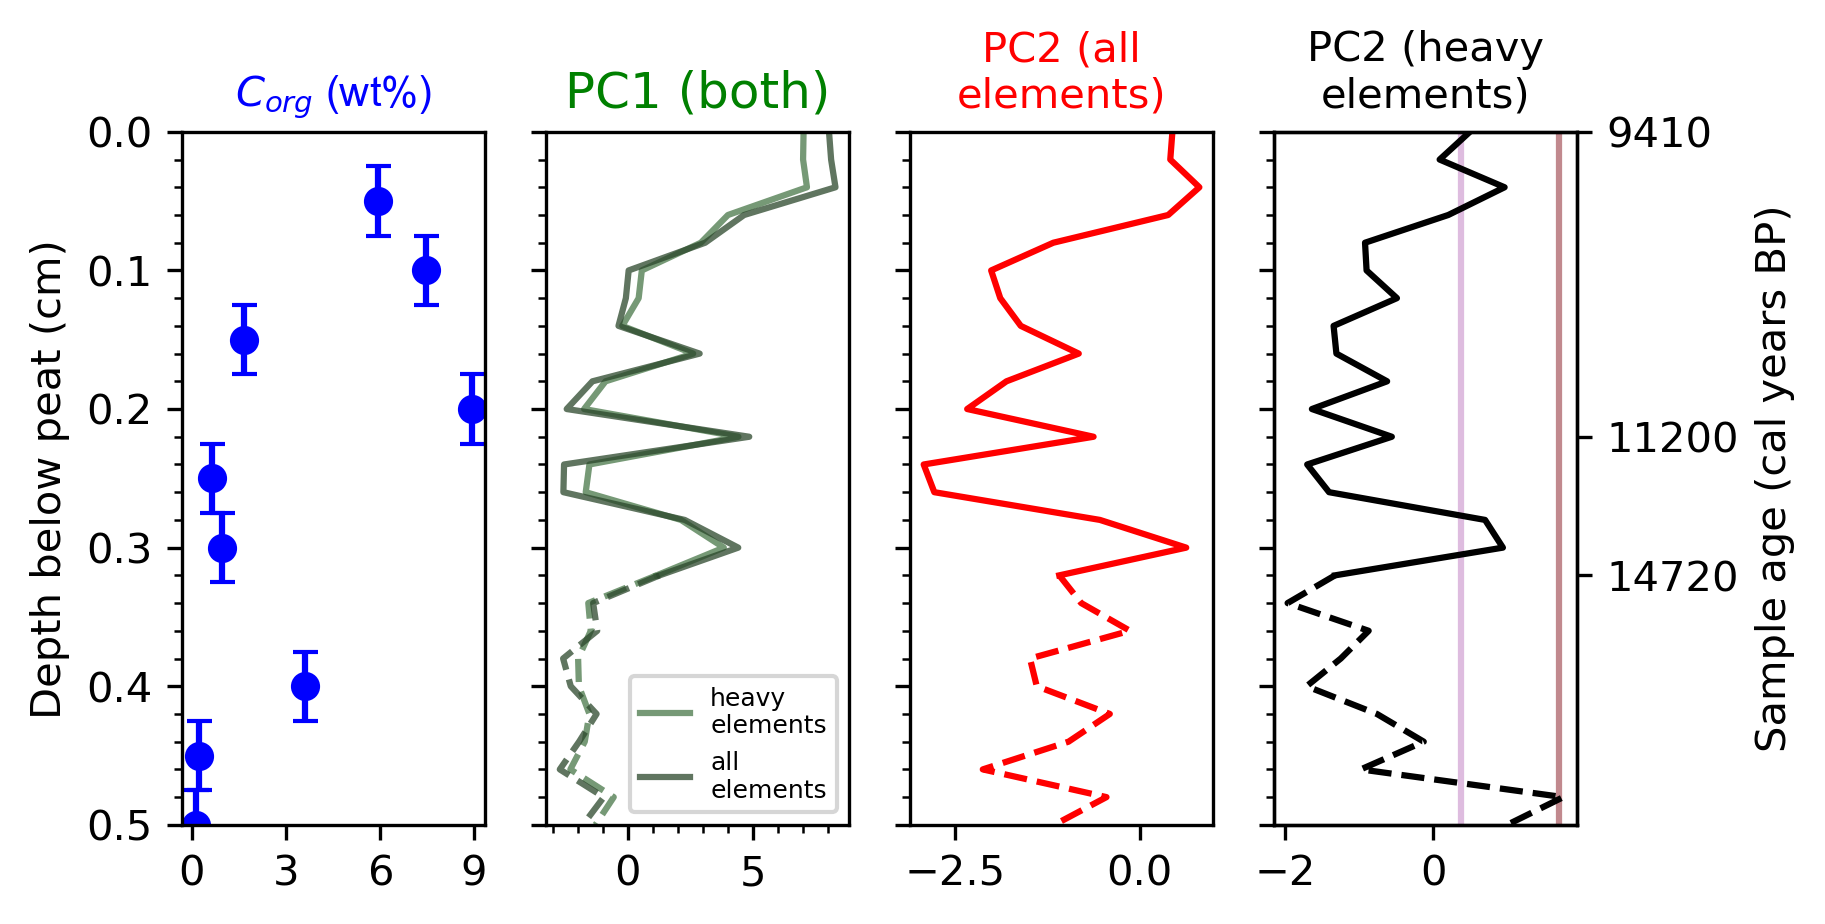

In [53]:
fig, ax = plt.subplots(1,4, figsize=(6, 3), dpi=300, sharey=True)


#, np.arange(0, agePCA.depth_adj.max(), .05)
# ax2.set_ylim(0.0, agePCA.age_extrapolated.max())
#ax2.set_ylim(agePCA.age_extrapolated.max(), agePCA.age_extrapolated.min())

ax[0].errorbar(result['%C'].values,
           result['depth_adj'].values,
              yerr=0.025,
               fmt="o",
               capsize=3,
               c='b'
              )

# ax[0].scatter(result['%C'].values,
#            result['depth_adj'].values,
#             c='b',
#             s=15
#            )


# ax[0].plot(result.loc[result['depth_adj'] <= 0.30,'%C'],
#            result.loc[result['depth_adj'] <= 0.30,'depth_adj'],
#            'b')
# ax[0].plot(result.loc[result['depth_adj'] > 0.30,'%C'],
#            result.loc[result['depth_adj'] > 0.30,'depth_adj'],
#            'b--')
ax[0].set_xticks(np.arange(0.0, 12.0, 3))
ax[0].set_title('$C_{org}$ (wt%)',fontsize=10, color='b',fontname='Arial')
ax[0].set_ylim(0.5, 0.0)
ax[0].set_ylabel("Depth below peat (cm)")



ax[1].plot(agePCA.loc[agePCA['depth_adj'] <= 0.32, 'PC1'],
           agePCA.loc[agePCA['depth_adj'] <= 0.32, 'depth_adj'], c='#487748', alpha=0.75, label='heavy\nelements')
ax[1].plot(agePCA.loc[agePCA['depth_adj'] > 0.3, 'PC1'],
           agePCA.loc[agePCA['depth_adj'] > 0.3, 'depth_adj'], c='#487748', ls='--', alpha=0.75)

ax[1].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'PC1'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'depth_adj'], c='#2b472b', alpha=0.75,label='all\nelements')
ax[1].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'PC1'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'depth_adj'], c='#2b472b', ls='--',alpha=0.75)

#ax[1].plot( agePCA_all_elements.PC1, agePCA.depth_adj,'#0f66e9', label='PC1')
ax[1].set_title("PC1 (both)", color='g')
ax[1].minorticks_on()
ax[1].legend(loc="lower right", prop={'size': 6})


ax[2].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'PC2'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] <= 0.32, 'depth_adj'], c='r', label='PC2')
ax[2].plot(agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'PC2'],
           agePCA_all_elements.loc[agePCA_all_elements['depth_adj'] > 0.3, 'depth_adj'], c='r', ls='--', label='PC2')
ax[2].set_title("PC2 (all\nelements)", color='r', fontsize=10)

# Plot PC2 bedrock and soil endmembers
ax[3].vlines(bedrock_PC2_mean, 0.0, 0.5, color='#84151E', alpha=0.5)
ax[3].vlines(soil_PC2_mean, 0.0, 0.5, color='#BF7AC1', alpha=0.5)


ax[3].plot(agePCA.loc[agePCA['depth_adj'] <= 0.32, 'PC2'],
           agePCA.loc[agePCA['depth_adj'] <= 0.32, 'depth_adj'], c='k', label='PC2')
ax[3].plot(agePCA.loc[agePCA['depth_adj'] > 0.3, 'PC2'],
           agePCA.loc[agePCA['depth_adj'] > 0.3, 'depth_adj'], c='k', ls='--', label='PC2')




ax[3].set_title("PC2 (heavy\nelements)", fontsize=10)

ax2 = ax[3].twinx()

ax2.plot(agePCA.PC2, agePCA.depth_adj, alpha=0.0)

agelist= [9410, 11200, 14720] #tounded to nearest decade
depthlist = [0.00, 0.22, 0.32]


ax2.set_ylim(0.5, 0.0)
ax2.set_ylabel("Sample age (cal years BP)")

# ticklist = [float(i.get_text()) for i in ax2.get_yticklabels()]
# For some reason this doesn't work in this block but will outside this block...
ticklist = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# So this is the cheesy fix
# age_labels = [f'{int(round(i,0))}' for i in agePCA.loc[agePCA.depth_adj.isin(ticklist), 'age_extrapolated'].values]
# ax2.set_yticklabels(age_labels);

age_labels = [f'{int(round(i,0))}' for i in agePCA.loc[agePCA.depth_adj.isin(depthlist), 'age_interpolated'].values]
ax2.set_yticks(depthlist)
# ax2.set_yticklabels(age_labels); # ya gotta round
ax2.set_yticklabels(agelist);
# Slices where detphs are equal to ticklist, labels them with the corresponding extrapolated age. 
# And also print formatted to the nearest whole number

#ax[0].set_ylim(agePCA.depth_adj.max(), agePCA.depth_adj.min())
fig.savefig('./output_figures/PCs_depth_time.png', dpi=300, bbox_inches='tight')

# Neotoma pollen plots

# Synthesizing regional pollen and stratigraphic data


In [28]:
bear1 = pd.read_csv("./bm_data/stingelin_correlation.csv")
bear2 = pd.read_csv("./bm_data/S02_core_log.csv")
bigpond = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/bigpond_pct.csv", encoding='latin-1')
browns = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/browns_pct.csv", encoding='latin-1')
cranb = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/cranb_pct.csv", encoding='latin-1')
crider = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/crider_pct.csv", encoding='latin-1')
hack = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/hack_pct.csv", encoding='latin-1')
panther = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/panther_pct.csv", encoding='latin-1')
potts = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/potts_pct.csv", encoding='latin-1')

bear1['median']=bear1['Age 3']
bear2['median']=bear2['age_interpolated']
bear2 = bear2.loc[bear2['median'] < 14800]
bear2['Total Alnus'] = np.nan

# sitelist = [bear1, bear2, bigpond, browns, cranb, crider, hack, panther, potts]
# sitenamelist = ['Bear Meadows center', 'Bear Meadows edge', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
#                 'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']
# sitenamelist_fig = ['Bear Meadows\ncenter', 'Bear Meadows\nedge (S-02)', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
#                 'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']

sitelist = [bear2, bigpond, browns, cranb, crider, hack, panther, potts]
sitenamelist = ['Bear Meadows edge', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
                'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']
sitenamelist_fig = ['Bear Meadows\nedge (S-02)', 'Big Pond', 'Browns Pond', 'Cranberry\nGlades', 'Criders Pond',
                'Hack Pond', 'Panther Run\nPond', 'Potts Mountain\nPond']

for frame in sitelist:
    Alnus_cols = [col for col in frame.columns if 'Alnus' in col]
    frame['Total Alnus'] = frame[Alnus_cols].sum(axis=1)
    
for frame in sitelist:
    if 'Poaceae' not in frame.columns:
        frame['Poaceae'] = 0

## Export a list of unique lithology textures from Neotoma cores

In [29]:
lith_list = []

lithsitelist = [bear1, bigpond, browns, cranb, crider, hack, panther, potts]
# bear2 doesn't have lithology that we use for this

for frame in lithsitelist:

    Alnus_cols = [col for col in frame.columns if 'Alnus' in col]
    frame['Total Alnus'] = frame[Alnus_cols].sum(axis=1)
    frame['Alnus norm'] = frame['Total Alnus']/frame['Total Alnus'].max()

    if 'Poaceae' not in frame.columns:
        frame['Poaceae'] = 0

    lith_list.append(frame.strat.unique().tolist())
    
lith_list_flat = [item for sublist in lith_list for item in sublist]
#https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists

lith_list = list(set(lith_list_flat))
#https://stackoverflow.com/questions/4459703/how-to-make-lists-contain-only-distinct-element-in-python

print(lith_list)

###ll_df = pd.DataFrame(lith_list)
### Lol please do not overwrite this file 
###ll_df.to_csv((os.path.join(strat_path,"strat2.csv")))

['organic clay', 'banded silt', 'gray silt', 'peat', 'peaty silt', 'peaty sandy clay', 'silty clay', 'fibrous peat', 'silt with black bands', 'dark-brown copropel', 'red clay', 'peaty clay', 'gray clay', 'clay', 'organic clay with stones', 'copropelic clay', 'silt with stones', 'organic silt', 'sandy red colluvial clay', 'sandy silt', 'gray and brown silty clay', 'brown clay', 'peat with silt']


## Assign coarse strat to fine strat

This is after one time I go in and assign more universal strat terms to site-specific terms

In [30]:
strat2 = pd.read_csv("./bm_data/regional_pollen_age_models_with_strat/strat2.csv")

strat_dict = pd.Series(strat2.coarse_strat.values, strat2.fine_strat.values,).to_dict()

sitenamelist = sitenamelist

bear2['strat'] = bear2['unit_desc']

In [31]:
for frame in sitelist:
    frame['strat_coarse'] = frame['strat'].map(strat_dict)

In [32]:
color_dict= {
    "coarse" : "aliceblue",
    "fine, inorg" : "lightsteelblue",
    "fine, org" : "rosybrown",
    "peat" : "darkred"
    
}

hatch_dict= {
    "coarse" : ".",
    "fine, inorg" : '',
    "fine, org" : '',
    "peat" : ''
    
}

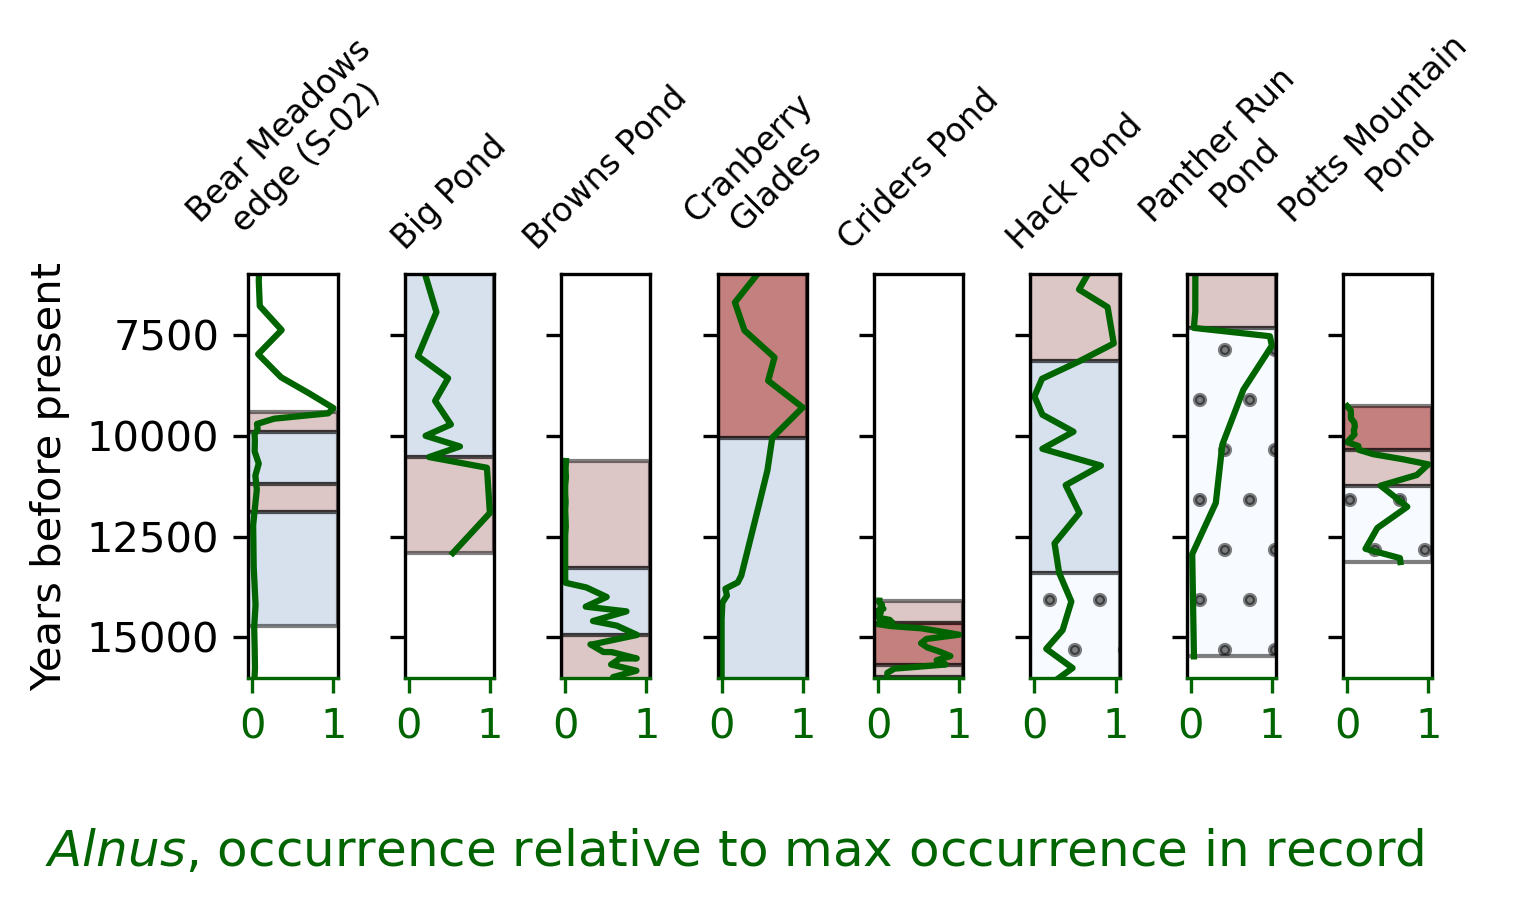

In [33]:
fig, ax = plt.subplots(1, len(sitelist), figsize=(5,3), dpi=300,
 sharey=True
 )

site_breaks = {}
site_textures = {}

# Loop through each site
for i, (frame, name) in enumerate(zip(sitelist, sitenamelist)):
    
    breaks_list = []
    texture_list = []
    
    # Loop through each time slice
    for j in range(1, len(frame)):
        if frame.strat_coarse.iloc[j] != frame.strat_coarse.iloc[j-1]:
            breaks_list.append(frame['median'].iloc[j])
            texture_list.append(frame['strat_coarse'].iloc[j])
    #Add first date
    breaks_list.insert(0,frame['median'].iloc[0])
    texture_list.insert(0,frame['strat_coarse'].iloc[0])
    #Add last date
    breaks_list.append(frame['median'].iloc[len(frame)-1])
    texture_list.append(frame['strat_coarse'].iloc[len(frame)-1])
#     print(sitenamelist[i])
#     print(breaks_list)
#     print(texture_list)
    
    # Key is site name, value is breaks and textures for sites 
    site_breaks[name] = breaks_list
    site_textures[name] = texture_list
    
    if name != 'Bear Meadows center':
        # Loop through each facies break point
        for k in range(1, len(breaks_list)):
            ax[i].axhspan(breaks_list[k-1], breaks_list[k], 
                        facecolor=color_dict[texture_list[k-1]], 
                        hatch=hatch_dict[texture_list[k-1]], 
                        edgecolor="black", 
                        alpha=0.5)

        if name == 'Bear Meadows edge':
            ax[i].plot(bear1['Alnus norm'],bear1['median'], color="darkgreen")
        else:
            ax[i].plot(frame['Alnus norm'],frame['median'], color="darkgreen")
    ax[i].xaxis.label.set_color('darkgreen')
    ax[i].tick_params(axis='x', colors='darkgreen')
    ax[i].spines['bottom'].set_color('darkgreen')
    # ax[i].set_xlabel('Alnus, %')
    ax[i].invert_yaxis()
    ax[i].set_title(sitenamelist_fig[i], fontsize=8, rotation=45)
    
#     ax2 = ax[i].twiny()
#     ax2.plot(frame['Quercus'],frame['median'], color="black")
#     ax2.xaxis.label.set_color('black')
#     ax2.tick_params(axis='x', colors='black')
#     ax2.spines['top'].set_color('black')
#     ax2.set_xlabel('Quercus, %')

ax[0].set_ylim((16000,6000))
ax[0].set_ylabel("Years before present")
fig.supxlabel('$\it{Alnus}$, occurrence relative to max occurrence in record', color="darkgreen", ha="center")
fig.tight_layout()
plt.savefig('./output_figures/all_stat.png',bbox_inches = "tight")
#ax[0].set_ylim(20000,0)

## Load spatial data and assign strat trends to spatial data

In [34]:
sites = pd.read_csv('./bm_data/regional_pollen_age_models_with_strat/regional_sites.csv', encoding='cp1252')

geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
crs = 'epsg:4326'
geo_df = GeoDataFrame(sites, crs=crs, geometry=geometry)

In [35]:
geo_df['Site name'].replace('Crider’s Pond', 'Criders Pond', inplace=True)
geo_df['Site name'].replace('Bear Meadows', 'Bear Meadows edge', inplace=True) #center


In [36]:
sitelist = [bear1, bigpond, browns, cranb, crider, hack, panther, potts]
sitenamelist = ['Bear Meadows edge', 'Big Pond', 'Browns Pond', 'Cranberry Glades', 'Criders Pond',
                'Hack Pond', 'Panther Run Pond', 'Potts Mountain Pond']
bear1['mean'] = bear1['Age 3']

In [37]:
org_breaks = []
for sites in geo_df['Site name']:
    if 'fine, inorg' in site_textures[sites]:
        org_break = site_breaks[sites][site_textures[sites].index('fine, inorg')]
    else:
        org_break = site_breaks[sites][site_textures[sites].index('coarse')]
    org_breaks.append(org_break)

geo_df['Inorg turnoff time'] = org_breaks


In [38]:
alnus_max_year = {}

for (frame, name) in zip(sitelist, sitenamelist):
    #alnus_max_year[name] = frame['cal kyrs'].loc[frame['Total Alnus'].idxmax()] * 1000
    alnus_max_year[name] = frame['mean'].loc[frame['Total Alnus'].idxmax()] 
    
df_alnus = pd.DataFrame.from_dict(alnus_max_year, orient="index", columns=["Alnus_max_time"])\
                                        .reset_index().rename(columns={"index":"Site name"})
df_siteinfo = pd.merge(geo_df,df_alnus, on="Site name")
df_siteinfo['Timing_div'] = df_siteinfo['Inorg turnoff time'] - df_siteinfo['Alnus_max_time'] 
df_siteinfo['Close?'] = 'Y'
df_siteinfo.loc[abs(df_siteinfo['Timing_div']) > 1000, 'Close?'] = 'N'


## Plot location of site and color by texture 

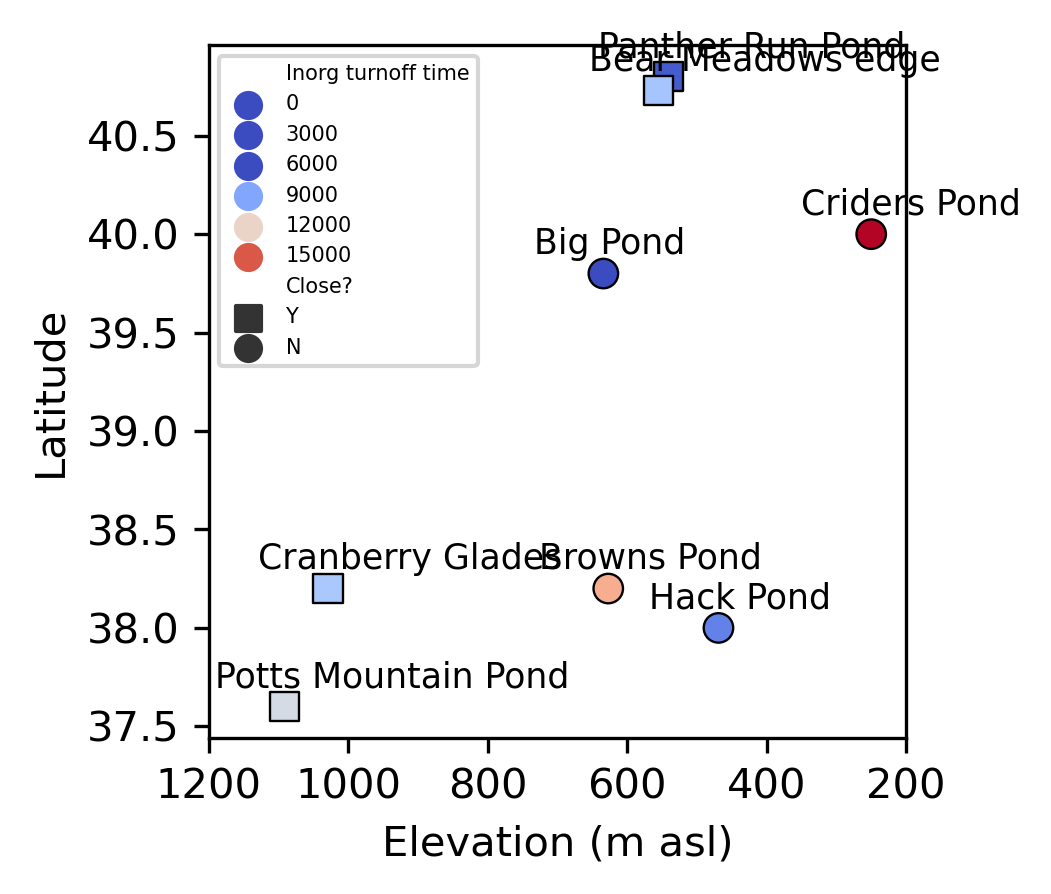

In [39]:

marker_dict = {'Y':'s', 'N':'o'}
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
scatter = sns.scatterplot(x=df_siteinfo['Elevation (m asl)'], y=df_siteinfo['Latitude'],
                          hue=df_siteinfo['Inorg turnoff time'],
                          palette='coolwarm',
                          style=df_siteinfo['Close?'],
                          markers=marker_dict,
                          edgecolor='k',
                          s=50,
                          ax=ax,
                          hue_norm=(7000,16000)
#                           vmin=7000,
#                           vmax=12000
                         )

for line in range(0,df_siteinfo.shape[0]):
     scatter.text(df_siteinfo['Elevation (m asl)'][line]+100.0, df_siteinfo['Latitude'][line]+0.1,
     df_siteinfo['Site name'][line], horizontalalignment='left', 
     size='small', color='black')

# https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn

scatter.legend(fontsize=5)
ax.set_xlim((1200, 200))

# outpathc = scatter.get_children()[9] 
# #TODO -- don't assume PathCollection is 4th; at least check type

# plt.colorbar(mappable=outpathc)

plt.savefig('./output_figures/strat_scatter.png')
plt.savefig('./output_figures/strat_scatter.svg')